In [1]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.multiclass import unique_labels
import os

#Import standard libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve, roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

In [2]:
 # load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainY1 = trainY
testY1 = testY


# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [3]:
trainX = trainX / 255.0
testX = testX / 255.0

In [4]:
classes = ["0","1","2","3","4","5","6","7","8","9"]

In [5]:
# To display confusion metric
def confusion_metric(testY, predY):
  print('Confusion Matrix')
  #print(confusion_matrix(y_test, y_pred))
  print('Classification Report')
  report = classification_report(testY, predY, target_names=classes)
  print(report)

In [6]:
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(testY, predY, average="macro"):
    # set plot figure size
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    
    lb = LabelBinarizer()
    lb.fit(testY)
    testY = lb.transform(testY)
    predY = lb.transform(predY)

    for (idx, c_label) in enumerate(classes):
        fpr, tpr, thresholds = roc_curve(testY[:,idx].astype(int), predY[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    multiclass_roc =  roc_auc_score(
        testY, predY, average=average)

    print(f'ROC AUC score:',{multiclass_roc}),# multiclass_roc_auc_score(y_test, y_pred))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

In [7]:
#functio for learning curve and accuracy plot
import sys
def summarize_diagnostics(history):
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
# plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')

  plt.show()
  plt.close()

In [8]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [10]:
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, model, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = model
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [ ]:
scores, histories = evaluate_model(trainX, trainY, model)

Epoch 1/50
750/750 [==============================] - 26s 34ms/step - loss: 0.2760 - accuracy: 0.9114 - val_loss: 0.0717 - val_accuracy: 0.9776
Epoch 2/50
750/750 [==============================] - 25s 33ms/step - loss: 0.0960 - accuracy: 0.9709 - val_loss: 0.0536 - val_accuracy: 0.9843
Epoch 3/50
750/750 [==============================] - 25s 33ms/step - loss: 0.0708 - accuracy: 0.9779 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 4/50
750/750 [==============================] - 27s 36ms/step - loss: 0.0611 - accuracy: 0.9809 - val_loss: 0.0439 - val_accuracy: 0.9871
Epoch 5/50
750/750 [==============================] - 26s 35ms/step - loss: 0.0497 - accuracy: 0.9841 - val_loss: 0.0407 - val_accuracy: 0.9883
Epoch 6/50
750/750 [==============================] - 24s 32ms/step - loss: 0.0466 - accuracy: 0.9851 - val_loss: 0.0353 - val_accuracy: 0.9906
Epoch 7/50
750/750 [==============================] - 25s 34ms/step - loss: 0.0428 - accuracy: 0.9864 - val_loss: 0.0397 - val_accuracy:

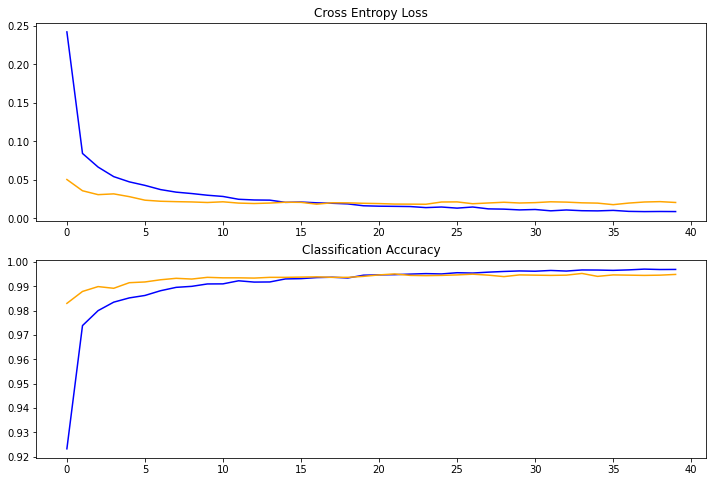

In [18]:
summarize_diagnostics(history)

In [19]:
accuracy = model.evaluate(testX, testY)

313/313 [==============================] - 5s 17ms/step - loss: 0.0268 - accuracy: 0.9950


In [20]:
predY = model.predict(testX)

In [21]:
predY[:1]

array([[2.8933803e-19, 1.3860109e-18, 3.9106502e-17, 5.7194740e-16,
        2.6963527e-14, 1.8492901e-18, 1.8285016e-22, 1.0000000e+00,
        3.9704404e-20, 5.7715745e-15]], dtype=float32)

In [22]:
predY = np.argmax(predY, axis = 1)

In [23]:
confusion_metric(testY1, predY)

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      0.99      0.99     10000



ROC AUC score: {0.997185647017325}


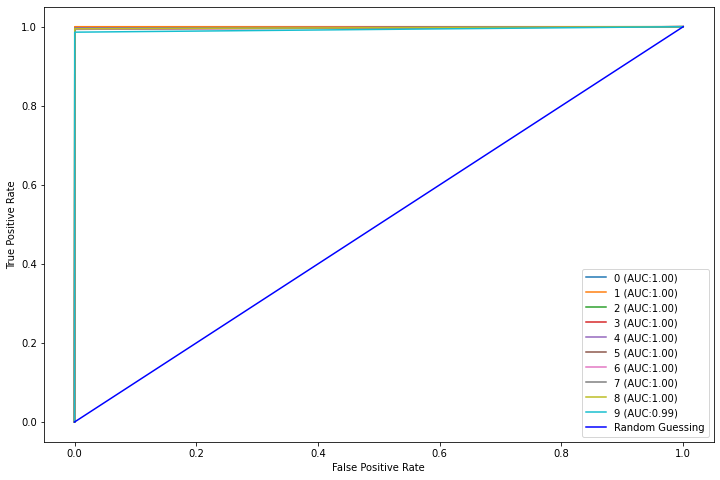

In [24]:
multiclass_roc_auc_score(testY1, predY)